# Input features
TODO
+ add padding at start to avoid errors if onset in first frame


In [1]:
import sys
sys.path.append('../')

from hvo_sequence.hvo_seq import HVO_Sequence

import os
import numpy as np
import pickle
import pandas as pd


### Load processed dataset

In [2]:
source_path = "../processed_dataset/Processed_On_27_04_2021_at_19_04_hrs"
print(os.path.join(source_path, "GrooveMIDI_processed_train", "hvo_data.obj"))
train_file = open(os.path.join(source_path, "GrooveMIDI_processed_train", "hvo_sequence_data.obj"),'rb')
train_set = pickle.load(train_file)
metadata = pd.read_csv(os.path.join(source_path, "GrooveMIDI_processed_train", "metadata.csv"))

features_in_metadata = list(metadata.columns)

dataset_size = len(train_set)

print("Dataset Size: %d \n Features: " % dataset_size, features_in_metadata)

../processed_dataset/Processed_On_27_04_2021_at_19_04_hrs/GrooveMIDI_processed_train/hvo_data.obj
Dataset Size: 17108 
 Features:  ['Unnamed: 0', 'drummer', 'session', 'loop_id', 'master_id', 'style_primary', 'style_secondary', 'bpm', 'beat_type', 'time_signature', 'full_midi_filename', 'full_audio_filename']


### Select random example

In [3]:
ix =  int(np.random.random_sample()*dataset_size)
print("Sample Number: %d, Primary Style: %s, Secondary Style: %s" % (ix, metadata["style_secondary"][ix], metadata["style_primary"][ix]))

example = train_set[ix]


Sample Number: 13707, Primary Style: latin, Secondary Style: funk


In [5]:
print(stft.shape)
numFrames = int(stft[0,:].size)
frmTime = hop_length*np.arange(numFrames)/float(sr); 
binFreq = np.arange(n_fft/2+1)*float(sr)/n_fft   
#plt.pcolormesh(frmTime, binFreq, librosa.amplitude_to_db(stft, ref=np.max))


(1025, 2290)


(1025, 2290)
/Users/pelinski/opt/anaconda3/envs/torch_thesis/lib/python3.6/site-packages/librosa/display.py:848: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  out = axes.pcolormesh(x_coords, y_coords, data, **kwargs)


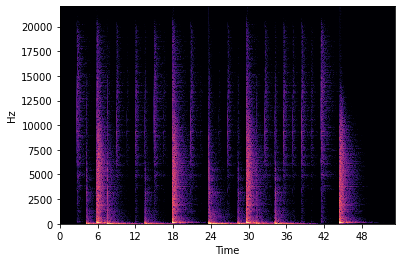

In [6]:
sr=44100
sf_path="../hvo_sequence/soundfonts/Standard_Drum_Kit.sf2"
n_fft=2048
hop_length=128
win_length=1024
window='hamming'
plot=True

#mel_spec = example.mel_spectrogram(sr=sr, sf_path=sf_path, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window = window, plot=plot)
#mel_spec.shape
stft = example.stft()
print(stft.shape)

#example.stft(plot=True)
import librosa.display
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_ylim(0,20000)
spec = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_coords=binFreq,  y_axis='linear',x_axis='time',ax=ax)


In [7]:
import librosa.onset as onset
y = example.save_audio()
o_strength = onset.onset_strength(S=mel_spec[0:200,:])
o_detect = onset.onset_detect(y=y) # saca los onsets para todas las bandas
print(o_strength[0:100])


NameError: name 'mel_spec' is not defined

### NMF
Features are frequency bins

[Text(0, 0.5, 'Components'), Text(0.5, 1.0, 'Activations')]

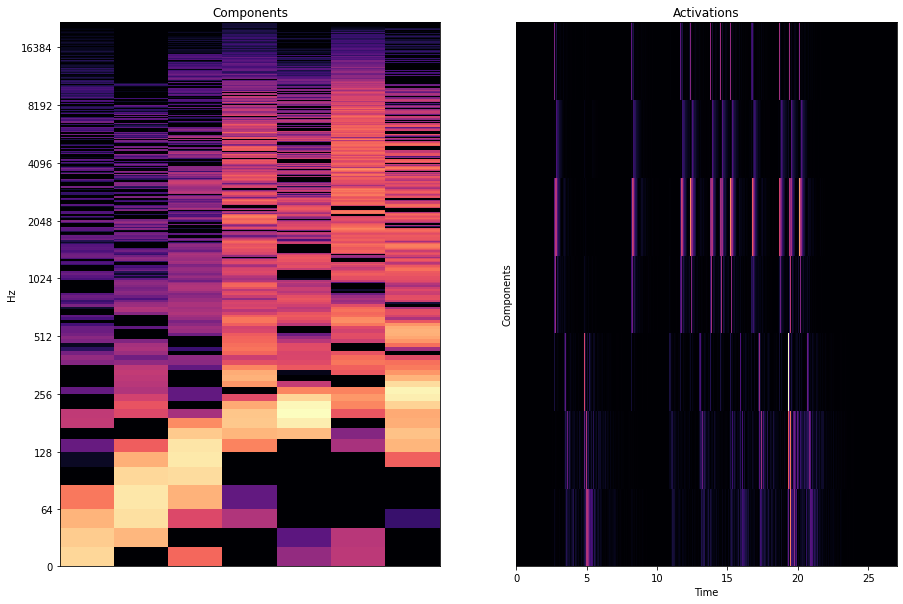

In [12]:
import librosa
import sklearn
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings("ignore")       # ignore librosa warnings

sr=44100
sf_path="../hvo_sequence/soundfonts/Standard_Drum_Kit.sf2"
n_fft=2048
hop_length=221              # this was from a paper
win_length=1024
window='hamming'
plot=True

# Get STFT
y = example.save_audio(sr=sr,sf_path=sf_path)
sy = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
stft = np.abs(sy)           # do not transform to db because db are negative
stft = stft/np.max(stft)    # normalize

# decomposition types (transformer types)
#T = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=9)
#T = sklearn.decomposition.PCA(n_components=9)
T = sklearn.decomposition.NMF(n_components=7)
comps, acts = librosa.decompose.decompose(stft, sort=True, transformer=T)

# plot
binFreq = np.arange(n_fft/2+1)*float(sr)/n_fft   
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
librosa.display.specshow(librosa.amplitude_to_db(comps,ref=np.max), y_axis='log', ax=ax[0],y_coords=binFreq)
ax[0].set(title='Components')
librosa.display.specshow(acts, x_axis='time', ax=ax[1])
ax[1].set(ylabel='Components', title='Activations')

In [18]:
example.to_html_plot(show_figure=True)

Figure(id='1002', ...)